<a href="https://colab.research.google.com/github/ksokoll/Invoice_Classification_LLM/blob/main/Invoice_Classification_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Invoice Creation and Classification with LLMs

The following Notebook illustrates a system, that is able to classify invoices and determine the correct cost_center based on chatGPT o3-mini / 4o-mini. We simulate a accounting use-case which is quite common in companies, as incoming invoices need to be labeled with the correct cost_type for adequate bookkeeping.

LLMs are powerful and offer a variety of benefits for invoice processing:

* Automation: LLMs can automate the invoice labeling process, saving time and resources.
* Accuracy: By using advanced models, the accuracy of classification is increased.
* Scalability: LLMs can efficiently process large volumes of invoices, which is particularly beneficial for growing businesses.
* Flexibility: The models can be adapted to different invoice formats and structures.

Since we are in the accounting-domain, a high accuracy has priority of the system has the most priority. The goal is a accuracy of a minimum of 95%, which means that 19/20 predictions are correct.

The notebook is structured as follows:

1. Create invoice dataset:
In this chapter 2500 example invoices get created for a total of 50 cost centers.

2. Classify invoices:
This chapter is all about the first run of the classification

3. Evaluation
The accuracy of the classification run gets interpreted with a focus on the low-accurracy categories

4. Inproving accuracy
With several more runs and experiments the accuracy of the LLM gets enhanced

5. Results
A short summary of the results of the above step as well as the notebook.



# 1 Create invoice dataset

First, we will create a set of 2500 artificial invoices as base for the further tests.

In [ ]:
!pip install instructor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.9/83.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.6/345.6 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: jiter
    Found existing installation: jiter 0.9.0
    Uninstalling jiter-0.9.0:
      Successfully uninstalled jiter-0.9.0


In [ ]:
!pip install python-dotenv

In [ ]:
import instructor

In [ ]:
from dotenv import load_dotenv

In [ ]:
import io
import os
from pydantic import BaseModel, Field
from openai import OpenAI
import numpy as np
import pandas as pd
import os
from pydantic import BaseModel, Field
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from enum import Enum
import plotly as plt
import seaborn as sns
import matplotlib.pyplot as plt


from google.colab import files
from google.colab import userdata
from collections import Counter

In [ ]:
# API Keys

key = userdata.get('OpenAIKey')

with open(".env", "w") as f:
    f.write(
        f"OPENAI_API_KEY='{key}'\n"
    )

# Load environment variable
load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
# 2. File

uploaded = files.upload()

# Check File
for file_name in uploaded.keys():
    print(f"File {file_name} has been uploaded and is available!")

Saving 2_replies_output_cleared_adjusted_cost_centers.csv to 2_replies_output_cleared_adjusted_cost_centers.csv
File 2_replies_output_cleared_adjusted_cost_centers.csv has been uploaded and is available!


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded[file_name]), encoding = 'UTF-8', delimiter = ';')

In [ ]:
# 3. OpenAI Client

client = instructor.from_openai(OpenAI()) # Setting API client

class Reply(BaseModel):
  content: str = Field(description="The answer to the query") # Set instructor Reply class

In [ ]:
# 4. System Prompt

systemPrompt = """Du bist ein Buchhalter, und deine Aufgabe ist das Schreiben einer fiktiven Beispielrechnung zu einer gewissen Kostenstelle. Bitte erwähne innerhalb der Rechnung nicht, dass es sich um ein fiktives Dokument handelt.

Das Dokument sollte einen fiktiven Rechnunssteller enthalten, sowie die entsprechenden Summen und Leistungsbeschreibungen.
Antwortformat:

Kostenstelle

Inhalt der fiktiven Rechnung zu der jeweiligen passenden Kostenart.

Die Kostenstelle lautet:

"""

# The systemprompt contains:
# 1. The role-allocation: The LLM gets told it is a accountant
# 2. The task: Its task is to write a fictional example invoice based on a certain cost_type
# 3. Specifics: It should not mention, that this is a artificial document
#

In [ ]:
replies = []

# Über jede Zeile iterieren
for _, row in df.iterrows():
    for _ in range(50):
        query = str(row.iloc[0])  # Erste Spalte der aktuellen Zeile
        print(query)

        reply = client.chat.completions.create(
            model="o3-mini",
            response_model=Reply,
            max_retries=3,
            messages=[
                {"role": "system", "content": systemPrompt},
                {"role": "user", "content": query}
            ]
        )

        replies.append(reply.content)
# Antworten in DataFrame umwandeln
df_replies = pd.DataFrame(replies, columns=["Response"])

There are double cost_types, also the cost_type is included in the samples which should not be the case. The data gets cleared now.

In [ ]:
df = df_replies

In [ ]:
# 4. Remove Cost-type information and put in separate column
df.iloc[:, 0] = df.iloc[:, 0].str[14:]

# Define the cost types
cost_types = [
    "_2867825", "_1419610", "_5614226", "_5108603", "_4744854",
    "_3341057", "_2719583", "_2458591", "_8078673", "_1533224",
    "_1499914", "_2571945", "_4668136", "_4903402", "_9478454",
    "_1445199", "_4335942", "_8038374", "_4698379", "_8536477",
    "_5667265", "_1109031", "_3678638", "_8090293", "_6708456",
    "_5661907", "_3608513", "_4612365", "_6647119", "_2714803",
    "_2556017", "_7374122", "_2622631", "_7022674", "_6770619",
    "_5437923", "_1728977", "_8707870", "_9996414", "_3094235",
    "_7350753", "_2322047", "_5918715", "_7067228", "_4226067",
    "_2166941", "_1768805", "_4823498", "_5855124", "_2338687"
]

# Assign invoices to blocks of their corresponding cost_types
def assign_cost_types(df, cost_types):
    num_rows = len(df)
    cost_type_list = []

    for i in range(num_rows):
        cost_type_list.append(cost_types[(i // 50) % len(cost_types)])

    df["cost_type"] = cost_type_list
    return df

# Finally, assign cost_types
df = assign_cost_types(df, cost_types)

# Remove unnecessary parts of the df
df.iloc[:, 0] = df.iloc[:, 0].str[21:]

# 2 Classify Invoices

For the classification I will use the instructor-library as guardrails,to get the LLM to olny answer in predefined categories.

In [ ]:
cost_type_mapping = {
    "_2867825": "Bewirtung",
    "_1419610": "Reisekosten",
    "_5614226": "Büromaterial",
    "_5108603": "IT_Ausstattung",
    "_4744854": "Fortbildungskosten",
    "_3341057": "Mietkosten",
    "_2719583": "Instandhaltung",
    "_2458591": "Versicherungen",
    "_8078673": "Gehälter",
    "_1533224": "Sozialabgaben",
    "_1499914": "Beratungskosten",
    "_2571945": "Marketingausgaben",
    "_4668136": "Telefonkosten",
    "_4903402": "Internetkosten",
    "_9478454": "Stromkosten",
    "_1445199": "Wasser_und_Abwasserkosten",
    "_4335942": "Reinigungskosten",
    "_8038374": "Sicherheitsdienst",
    "_4698379": "Lizenzgebühren",
    "_8536477": "Software_Abonnements",
    "_5667265": "Druckkosten",
    "_1109031": "Versandkosten",
    "_3678638": "Fuhrparkmanagement",
    "_8090293": "Leasingkosten",
    "_6708456": "Rechtskosten",
    "_5661907": "Steuerberatungskosten",
    "_3608513": "Bankgebühren",
    "_4612365": "Zinsen",
    "_6647119": "Abschreibungen",
    "_2714803": "Spenden",
    "_2556017": "Mitgliedsbeiträge",
    "_7374122": "Werbekosten",
    "_2622631": "Veranstaltungskosten",
    "_7022674": "Catering",
    "_6770619": "Personalbeschaffung",
    "_5437923": "Arbeitskleidung",
    "_1728977": "Gesundheitsvorsorge",
    "_8707870": "Reparaturen",
    "_9996414": "Wartungskosten",
    "_3094235": "Lagerkosten",
    "_7350753": "Transportkosten",
    "_2322047": "Verpackungskosten",
    "_5918715": "Forschung_und_Entwicklung",
    "_7067228": "Patentanmeldungen",
    "_4226067": "Umweltkosten",
    "_2166941": "Entsorgungskosten",
    "_1768805": "Schulungskosten",
    "_4823498": "Reisekosten_für_Kundenbesuche",
    "_5855124": "Kosten_für_externe_Dienstleister",
    "_2338687": "Kosten_für_interne_Projekte"
}

In [ ]:
# Instructor Categories and System Prompt

class CostType(str, Enum):
    _2867825 = "Bewirtung"
    _1419610 = "Reisekosten"
    _5614226 = "Büromaterial"
    _5108603 = "IT_Ausstattung"
    _4744854 = "Fortbildungskosten"
    _3341057 = "Mietkosten"
    _2719583 = "Instandhaltung"
    _2458591 = "Versicherungen"
    _8078673 = "Gehälter"
    _1533224 = "Sozialabgaben"
    _1499914 = "Beratungskosten"
    _2571945 = "Marketingausgaben"
    _4668136 = "Telefonkosten"
    _4903402 = "Internetkosten"
    _9478454 = "Stromkosten"
    _1445199 = "Wasser_und_Abwasserkosten"
    _4335942 = "Reinigungskosten"
    _8038374 = "Sicherheitsdienst"
    _4698379 = "Lizenzgebühren"
    _8536477 = "Software_Abonnements"
    _5667265 = "Druckkosten"
    _1109031 = "Versandkosten"
    _3678638 = "Fuhrparkmanagement"
    _8090293 = "Leasingkosten"
    _6708456 = "Rechtskosten"
    _5661907 = "Steuerberatungskosten"
    _3608513 = "Bankgebühren"
    _4612365 = "Zinsen"
    _6647119 = "Abschreibungen"
    _2714803 = "Spenden"
    _2556017 = "Mitgliedsbeiträge"
    _7374122 = "Werbekosten"
    _2622631 = "Veranstaltungskosten"
    _7022674 = "Catering"
    _6770619 = "Personalbeschaffung"
    _5437923 = "Arbeitskleidung"
    _1728977 = "Gesundheitsvorsorge"
    _8707870 = "Reparaturen"
    _9996414 = "Wartungskosten"
    _3094235 = "Lagerkosten"
    _7350753 = "Transportkosten"
    _2322047 = "Verpackungskosten"
    _5918715 = "Forschung_und_Entwicklung"
    _7067228 = "Patentanmeldungen"
    _4226067 = "Umweltkosten"
    _2166941 = "Entsorgungskosten"
    _1768805 = "Schulungskosten"
    _4823498 = "Reisekosten_für_Kundenbesuche"
    _5855124 = "Kosten_für_externe_Dienstleister"
    _2338687 = "Kosten_für_interne_Projekte"

In [ ]:
# Define ReplyModel and Systemprompt
class Reply(BaseModel):
  content: str = Field(description="The answer to the query")
  category: CostType = Field(description="The category of the cost type")
  confidence: float = Field(ge = 1, le = 100, description = "Confidence in category")


systemPrompt = """Du bist ein Buchhalter, und deine Aufgabe ist das klassifizieren von Rechnungen. Nutze hierzu eine der vorgegebenen cost_type Kategorien.
"""

In [ ]:
# For testing: Take samples

df_sample = df.sample(n=50, random_state=2)
df_sample = df_sample.reset_index(drop=True)

In [ ]:
replies = []
confidences = []

# Über jede Zeile iterieren
for _, row in df_sample.iterrows():
        query = str(row.iloc[0])  # Erste Spalte der aktuellen Zeile
        #print(query)

        reply = client.chat.completions.create(
            model="o3-mini",
            response_model=Reply,
            max_retries=3,
            messages=[
                {"role": "system", "content": systemPrompt},
                {"role": "user", "content": query}
            ]
        )

        replies.append(reply.category.name)
        confidences.append(reply.confidence)
        print(reply.category.name)

_2714803
_7374122
_1499914
_9996414
_1499914
_7374122
_2714803
_9996414
_1499914
_4226067
_9996414
_2622631
_2719583
_1768805
_8707870
_2719583
_9996414
_2338687
_5855124
_7374122
_4744854
_2338687
_2714803
_1499914
_5855124
_1499914
_1499914
_1499914
_2338687
_2719583
_5855124
_5855124
_7374122
_4226067
_2571945
_4226067
_1499914
_2714803
_2571945
_5855124
_1499914
_1499914
_8707870
_8707870
_8707870
_5855124
_2719583
_1499914
_1499914
_9996414


In [ ]:
# Reframe the answers in a datatable
df_sample_replies = pd.DataFrame(replies, columns=["Response"])
df_sample_replies["Confidence"] = confidences

df_sample["reply_category"] = df_sample_replies["Response"].values
df_sample["confidence"] = df_sample_replies["Confidence"].values

As a result we now have a datatable "df_sample" filled with the results

# 3 Evaluation

## 3.1 Evaluation of the Accuracy per cost_type

In [ ]:
# Analysis of the responses

df_sample["comparison_result"] = df_sample["cost_type"] == df_sample["reply_category"]

print(df_sample)

match_count = df_sample["comparison_result"].sum()
print(f"Anzahl der Übereinstimmungen: {match_count}/{len(df_sample)}")

                                             Response cost_type  \
0   ller: Hilfswerk Linden e.V.\nRechnungsdatum: 1...  _2714803   
1   ller: Kreativagentur Professions GmbH\nAdresse...  _2571945   
2   --------------------------------------\nRechnu...  _4226067   
3   ller: Technische Wartungs GmbH\nAdresse: Muste...  _9996414   
4   ller: Innovative Wirtschaftslösungen GmbH\n\nL...  _2338687   
5   hnungssteller: KreativWerbung GmbH\nRechnungsn...  _2571945   
6   hnungssteller: Stiftung für Kultur und Soziale...  _2714803   
7   ller: Wartungs- und Service GmbH\n\nLeistungsb...  _9996414   
8   ller: Muster-Service AG\nAdresse: Musterstraße...  _5855124   
9   ller: UmweltService AG\nAdresse: Musterstraße ...  _4226067   
10  ller: TechService GmbH\nAnschrift: Innovations...  _9996414   
11  ller: Wohltätigkeitsverein Lebensfreude e.V.\n...  _2714803   
12  -------------------------------------\nRechnun...  _9996414   
13  chnungssteller: Schulungszentrum Akademia GmbH...  _176880

In [ ]:
# 2. File

import io

uploaded = files.upload()

# Check File
for file_name in uploaded.keys():
    print(f"File {file_name} has been uploaded and is available!")

Saving 4_invoice_classification_run_3.csv to 4_invoice_classification_run_3.csv
File 4_invoice_classification_run_3.csv has been uploaded and is available!


In [ ]:
df_1 = pd.read_csv(io.BytesIO(uploaded[file_name]), encoding = 'UTF-8', delimiter = ',')

In [ ]:
df_2 = pd.read_csv(io.BytesIO(uploaded[file_name]), encoding = 'UTF-8', delimiter = ',')

In [ ]:
df_3 = pd.read_csv(io.BytesIO(uploaded[file_name]), encoding = 'UTF-8', delimiter = ',')

In [ ]:
df_combined = pd.concat([df_1, df_2, df_3], ignore_index=True)

In [ ]:
df_combined

,Response,cost_type,reply_category,confidence,comparison_result
0,fänger: Musterfirma AG\n\nRechnungssteller: Re...,_1419610,_1419610,100.0,True
1,chnungssteller: Reiselinie GmbH\nAdresse: Must...,_4823498,_4823498,100.0,True
2,ller: ABC Training GmbH\nAdresse: Beispielstra...,_1768805,_4744854,100.0,False
3,ller: Energie & Service AG\nAdresse: Musterstr...,_9478454,_9478454,95.0,True
4,"ler: Security Services GmbH, Musterstraße 12, ...",_8038374,_8038374,100.0,True
...,...,...,...,...,...
895,chnungssteller: FinanzenPlus GmbH\nAdresse: Mu...,_2714803,_1499914,95.0,False
896,ller: Fracht-Logistik GmbH\n\nRechnungsnummer:...,_7350753,_7350753,95.0,True
897,"ller: MetroBank AG\nAdresse: Hauptstraße 45, 1...",_3608513,_3608513,99.0,True
898,ller: WasserTech GmbH\nAdresse: Musterstraße 1...,_1445199,_1445199,100.0,True


--------

In [ ]:
# Group by cost_type and sum the amount

df_grouped = df_combined.groupby('cost_type').agg(
    mean_comparison=('comparison_result', 'mean'),
    count=('cost_type', 'size')
).reset_index()

In [ ]:
unique_count = df['cost_type'].nunique()
unique_count

50

In [ ]:
df_grouped['count'].min()

10

There have been at least 10 samples of each cost_type, which is a good sample population.

Next, lets have a look on the accuracy of the classifications.

In [ ]:
true_count = (df_combined['comparison_result'] == True).sum()
true_count

np.int64(805)

**Interpretation:** A total of 805/900 invoices have been classified correctly, which is already a good result of 89,44% accuracy.

Goal with the next steps is to raise this accuracy to at minimum 95%, more optimally it would be 99%, or at least to have a indicator to put a human in the loop with a confidence mechanism.

To proceed with that, we can ignore the cost_types which have a accuracy rate of 100%, and focus on the ones with lower rates.

In [ ]:
df_filtered = df_grouped.loc[df_grouped['mean_comparison'] != 1.000000] # Filtering the df for all categories that do not have 100% accurate classifications

In [ ]:
df_sorted = df_filtered.sort_values(by='mean_comparison', ascending=True) # Sorting the filtered df ascending

In [ ]:
unique_count_filtered = df_filtered['cost_type'].nunique() # Counting the unique cost_types in the dataframe which are not accurate
unique_count_filtered

22

A total of 22 cost_types have not 100% accuracy, which is almost half of all cost_types!

<ipython-input-65-aedfb41d7163>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_sorted["cost_type"], y=df_sorted["mean_comparison"], palette="Blues_r")


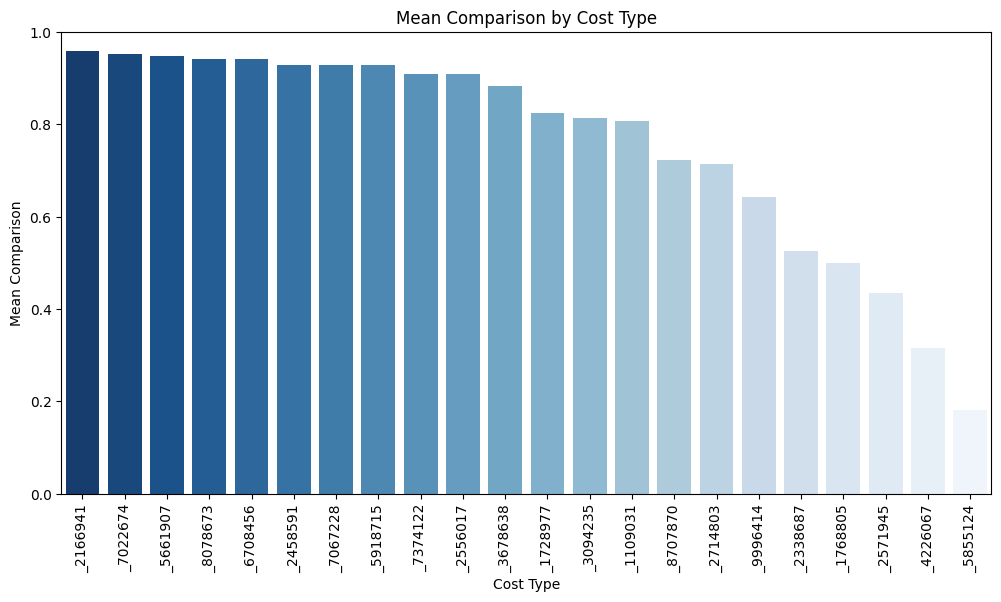

In [ ]:
df_sorted = df_sorted.sort_values(by="mean_comparison", ascending=False)

# Plot erstellen
plt.figure(figsize=(12, 6))
sns.barplot(x=df_sorted["cost_type"], y=df_sorted["mean_comparison"], palette="Blues_r")

# Achsentitel und Styling
plt.xlabel("Cost Type")
plt.ylabel("Mean Comparison")
plt.title("Mean Comparison by Cost Type")
plt.ylim(0, 1)  # Wertebereich 0 bis 1 festlegen
plt.xticks(rotation=90)  # X-Achsen-Beschriftung drehen, falls viele Einträge

plt.show()

## 3.2 Evaluation of the confidence for the low accuracy cost_types

Next, I want to find out if the confidence stated by the model is a good indicator of a low accuracy for the cost_type.

In [ ]:
# Evaluating confidence

df_grouped_confidence = df.groupby('cost_type')['confidence'].mean().reset_index() # Calculating the mean confidence of each cost_type

df_filtered_confidence = df_grouped_confidence.loc[df_grouped_confidence['confidence'] != 100] # Excluding cost_types with 100% confidence

df_filtered_confidence = df_filtered_confidence.sort_values(by='confidence', ascending=True) # Sort df ascending

Overall, the model is quite confident in its responses. Lets compare the lowest confidences with the cost_types wich have proven to have a low accuracy.

In [ ]:
df_merged = df_grouped.merge(df_grouped_confidence, on="cost_type", how="inner") # Merge the confidence with the original df
df_merged['mean_comparison'] = df_merged['mean_comparison'] * 100 # Calculating times 100 to enhance comparability

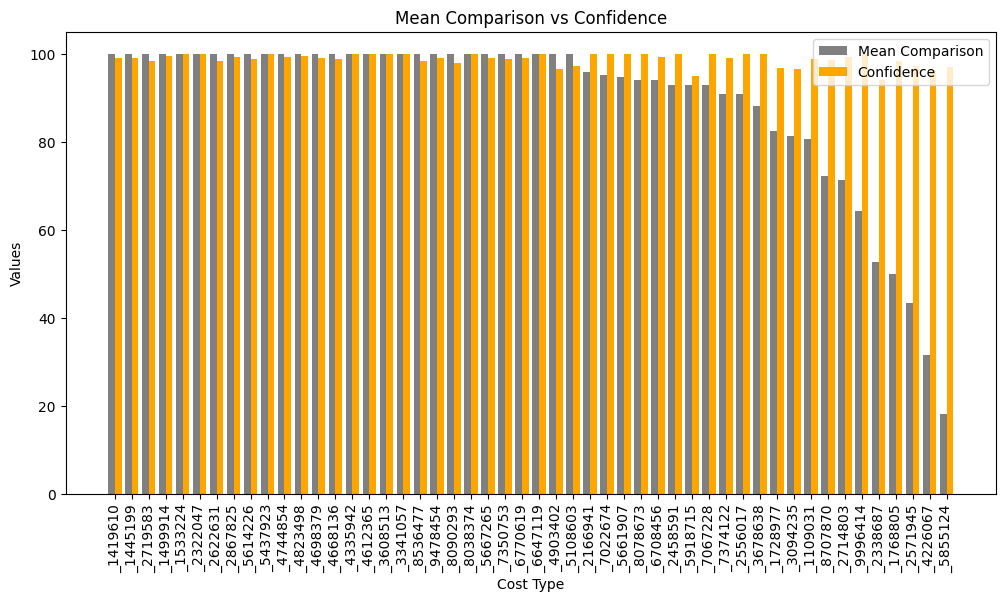

In [ ]:
# Set the with of the bars
bar_width = 0.4

# Calculate x positions
x = np.arange(len(df_merged["cost_type"]))

# Create diagram
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width/2, df_merged["mean_comparison"], width=bar_width, label="Mean Comparison", color="grey")
plt.bar(x + bar_width/2, df_merged["confidence"], width=bar_width, label="Confidence", color="orange")

# Axis-Labels
plt.xlabel("Cost Type")
plt.ylabel("Values")
plt.title("Mean Comparison vs Confidence")
plt.xticks(x, df_merged["cost_type"], rotation=90)  # Set X axis label
plt.legend()  # Show legend

plt.show()

For certain cost_types a slight correlation between lower confidence and lower accurracy can be seen. However, it is not significant enough to take the confidence as a solid indicator.

## 3.3 Further evaluation of the low accuracy cost_types

Since the confidence the model reports cannot be used as a reference for trouble with determining the correct category, we have to find other methods.

First, lets isolate the cost_types that have low accuracy and dive a bit deeper.

In [ ]:
cost_types_list = ['_5855124', '_4226067', '_2571945', '_1768805', '_2338687',
                  '_9996414', '_2714803', '_8707870', '_1109031', '_3094235',
                  '_1728977', '_3678638', '_2556017', '_7374122', '_5918715',
                  '_2458591', '_7067228', '_8078673', '_6708456', '_5661907',
                  '_7022674', '_2166941'] # This is the list of all cost_types with < 100% accuracy

In [ ]:
df_filtered = df[df['cost_type'].isin(cost_types_list)] # Filtering the original invoice data for the above cost_types

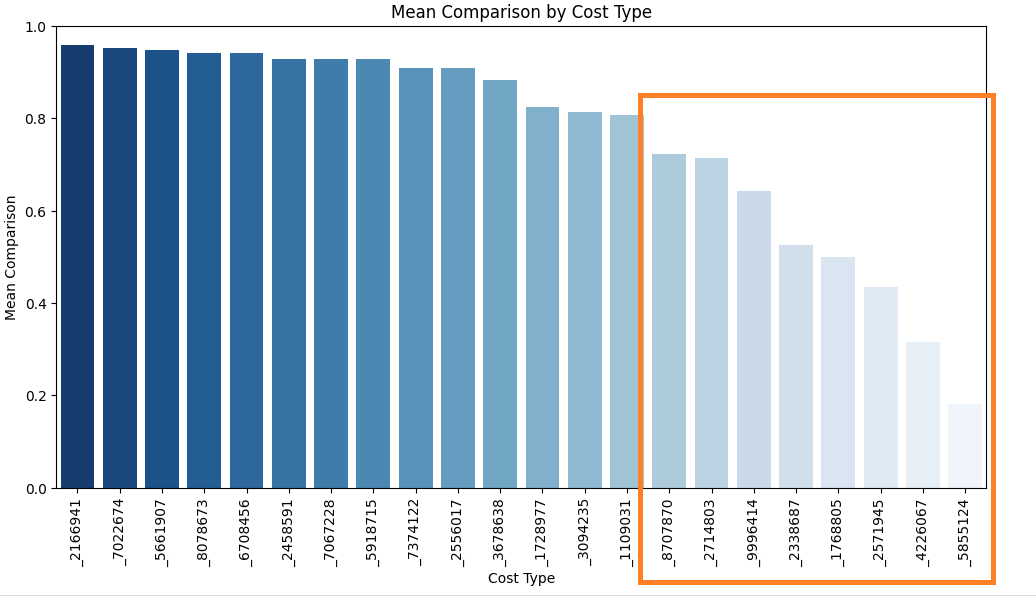

The categories with the lowest accuracy are (descending, starting with lowest accuracy):

_5855124 = "Kosten_für_externe_Dienstleister" = Costs for external service providers

_4226067 = "Umweltkosten" = Environmental costs

_2571945 = "Marketingausgaben" = Marketing costs

_1768805 = "Schulungskosten" = Training costs

_2338687 = "Kosten_für_interne_Projekte" = Costs for external projects

_9996414 = "Wartungskosten" = Maintanance costs

_2714803 = "Spenden" = Donations

_8707870 = "Reparaturen" = Repairs














One interesting idea is to evaluate is: What are the categories that the model is switching up? Maybe there are ambiguous or double categories, where it is difficult in the first place to find the correct one.

In [ ]:
result = df.groupby('cost_type')['reply_category'].nunique().reset_index() # Group df by unique cost_types
result.sort_values(by='reply_category', ascending=False) # Sort resulting df descending
result = result.loc[result['reply_category'] != 1] # Exclude all cost_types that have exactely 1 predicted cost_type which is a indicator for non ambiguous categories
result

,cost_type,reply_category
0,_1109031,2
5,_1728977,2
6,_1768805,2
9,_2338687,3
12,_2571945,2
14,_2714803,2
21,_4226067,2
34,_5855124,2
37,_6708456,2
44,_8078673,2


Indeed, there are 12 cost_types that the model seens to switch up.

Next, I suspect that those switched up cost_types are also the ones that have the lowest accuracy:

In [ ]:
result_merged = result.merge(df_grouped, on="cost_type", how="inner") # Merge the cost_types that have been identified as ambiguous categories with their accuracy

In [ ]:
result_merged

,cost_type,reply_category,mean_comparison,count
0,_1109031,2,0.916667,12
1,_1728977,2,0.857143,7
2,_1768805,2,0.444444,9
3,_2338687,3,0.285714,7
4,_2571945,2,0.142857,7
5,_2714803,2,0.857143,7
6,_4226067,2,0.333333,9
7,_5855124,2,0.200000,5
8,_6708456,2,0.857143,7
9,_8078673,2,0.888889,9


It gets obvious that the cost_types with the lowest accuracy are also cost_types where the model is not sure which cost_type to apply.

To get a better Idea why, we can list the specific cost_types to understand why they get switched up.

In [ ]:
result['reply_category_list'] = df.groupby('cost_type')['reply_category'].transform(lambda x: ';'.join(set(x))) # Grouping the details of the cost_types to "reply_category" as a comma separated list

In [ ]:
split_columns = result['reply_category_list'].str.split(';', expand=True).iloc[:, :3] # Splitting the comma separated list. I chose 3 because this is the maximum of wrong predicted cost_types per type.
split_columns.columns = ['reply_category_1', 'reply_category_2', 'reply_category_3'] # Create new columns to receive the values
result = pd.concat([result, split_columns], axis=1) # Add the new columns to the result dataframe
result = result.drop(columns=['reply_category_list', 'reply_category']) # Drop columns that are not longer needed
result

,cost_type,reply_category_1,reply_category_2,reply_category_3
0,_1109031,_1419610,None,None
5,_1728977,_2622631,None,None
6,_1768805,_6647119,None,None
9,_2338687,_9478454,None,None
12,_2571945,_2719583,None,None
14,_2714803,_5667265,None,None
21,_4226067,_5855124,_2338687,_1499914
34,_5855124,_5855124,_8078673,None
37,_6708456,_1445199,None,None
44,_8078673,_5855124,_8078673,None


To enhance visibility, the cost_types are now replaced by their category descriptions

In [ ]:
columns_to_replace = ['cost_type', 'reply_category_1', 'reply_category_2', 'reply_category_3'] # Choose the columns

for column in columns_to_replace:
    result[column] = result[column].map(cost_type_mapping) # For each column: Swap the encoded cost_types with their descriptions

In [ ]:
result

,cost_type,reply_category_1,reply_category_2,reply_category_3
0,Versandkosten,Reisekosten,NaN,NaN
5,Gesundheitsvorsorge,Veranstaltungskosten,NaN,NaN
6,Schulungskosten,Abschreibungen,NaN,NaN
9,Kosten_für_interne_Projekte,Stromkosten,NaN,NaN
12,Marketingausgaben,Instandhaltung,NaN,NaN
14,Spenden,Druckkosten,NaN,NaN
21,Umweltkosten,Kosten_für_externe_Dienstleister,Kosten_für_interne_Projekte,Beratungskosten
34,Kosten_für_externe_Dienstleister,Kosten_für_externe_Dienstleister,Gehälter,NaN
37,Rechtskosten,Wasser_und_Abwasserkosten,NaN,NaN
44,Gehälter,Kosten_für_externe_Dienstleister,Gehälter,NaN


Looking through the validation results, it seems that there are ambiguous cost_types, which are hard to differenciate.

_2719583 = "Instandhaltung"
_9996414 = "Wartungskosten"

Those two cost_types are almost the same



---



_7374122 = "Werbekosten"
_2571945 = "Marketingausgaben"

also almost the same

---

_2338687 = "Kosten_für_interne_Projekte"
_1499914 = "Beratungskosten"
-> Not the same, but Cost for internal projects can incorporate consulting costs. Therefore, a differentiation is hard, even for me.

---

**Interpretation**: The model took reasonable steps to identify the cost_type. The problem are ambiguous categories, as one invoice can absolutely fit into several categories.

How to deal with this issue?
In the real world these cases would be either excluded from the automation, or vendor-specific rules would be implemented (for example: For Vendor ABC, if faced with two fitting cost_types, choose "Marketing"). The latter is not feasible though in this project, as there are no repetitive vendors for certain cost_types, as they are produced randomly.



# 4 Improving accuracy through an ensemble

Now that we know that ambiguous categories are a issue, one more test comes to mind.

Instead of only one prediction per invoice, we can do multiple predictions. My guess is that the cost_types that are non-ambiguous produce the same cost_type, while more ambiguous categories will result in different cost_types, which then can be marked as "manual_check" to have them sorted out for a human-in-the-loop approach.

To get a first idea, lets take 50 samples with 3 predictions per invoice instead of 1.

## 4.1 First experiment with 50 Samples

In [ ]:
# For testing: Take samples

df_sample = df.sample(n=50, random_state=2) # Take 50 samples with random state 2
df_sample = df_sample.reset_index(drop=True) # Drop the indices to remove empty rows

In [ ]:
# Define ReplyModel and Systemprompt
class Reply(BaseModel):
  content: str = Field(description="The answer to the query")
  category: CostType = Field(description="The category of the cost type")


systemPrompt = """Du bist ein Buchhalter, und deine Aufgabe ist das klassifizieren von Rechnungen. Nutze hierzu eine der vorgegebenen cost_type Kategorien.
"""

In [ ]:
replies = []

# Über jede Zeile iterieren
for _, row in df_sample.iterrows():
    query = str(row.iloc[0])  # Erste Spalte der aktuellen Zeile
    #print(query)

    reply_categories = []

    for _ in range(3):  # Drei Vorhersagen pro Zeile durchführen
        reply = client.chat.completions.create(
            model="o3-mini",
            response_model=Reply,
            max_retries=3,
            messages=[
                {"role": "system", "content": systemPrompt},
                {"role": "user", "content": query}
            ]
        )
        reply_categories.append(reply.category.name)

    replies.append(';'.join(reply_categories))
    print(';'.join(reply_categories))

# Ergebnisse in DataFrame speichern
df_sample['reply_categories'] = replies

print(df_sample)

In [ ]:
split_columns = df_sample['reply_categories'].str.split(';', expand=True).iloc[:, :3]
split_columns.columns = ['prediction_1', 'prediction_2', 'prediction_3']
result = pd.concat([df_sample, split_columns], axis=1)

In [ ]:
result = result.drop(columns=['reply_categories', 'Response'])

In [ ]:
result['predictions_same'] = (result['prediction_1'] == result['prediction_2']) & (result['prediction_2'] == result['prediction_3'])

In [ ]:
result['prediction_correct'] = result.apply(lambda row: row['cost_type'] == row['prediction_1'] if row['predictions_same'] else False, axis=1)

In [ ]:
result['predictions_correct_and_same'] = result.apply(lambda row: row['predictions_same'] and row['prediction_correct'], axis=1)

In [ ]:
result_filtered = result.loc[result['predictions_correct_and_same'] == False]

KeyError: 'predictions_correct_and_same'

In [ ]:
result_filtered

,cost_type,prediction_1,prediction_2,prediction_3,predictions_same,prediction_correct,predictions_correct_and_same
2,_7374122,_2571945,_7374122,_7374122,False,False,False
4,_3678638,_8090293,_8090293,_8090293,True,False,False
14,_2338687,_5855124,_1499914,_5855124,False,False,False
21,_4226067,_1499914,_1499914,_1499914,True,False,False
26,_2714803,_5855124,_5855124,_5855124,True,False,False
39,_3678638,_3678638,_3678638,_5855124,False,False,False
42,_2714803,_1499914,_1499914,_1499914,True,False,False
47,_4226067,_4226067,_1499914,_1499914,False,False,False


**Interpretation:** In the above table we see that of the 50 samples a total of 8 samples have been classified incorrectly.

Of this 8 wrong classifications there were 4 that have been classified three times in a row with the wrong class (True-False), where the other 4 samples have different predictions (False-False).

Though not all wrong predictions could be sorted out this way, this method at least catched 50% of the wrong predictions in this sample without knowing the label, making it a indicator for model uncertainty.

To prove this, a bigger run of 300 samples to increase statistical significance is conducted.



## 4.2 Second experiment with 300 Samples

In [ ]:
# For testing: Take samples

df_sample = df.sample(n=300, random_state=3)
df_sample = df_sample.reset_index(drop=True)

In [ ]:
replies = []

# Über jede Zeile iterieren
for _, row in df_sample.iterrows():
    query = str(row.iloc[0])  # Erste Spalte der aktuellen Zeile
    #print(query)

    reply_categories = []

    for _ in range(3):  # Drei Vorhersagen pro Zeile durchführen
        reply = client.chat.completions.create(
            model="o3-mini",
            response_model=Reply,
            max_retries=3,
            messages=[
                {"role": "system", "content": systemPrompt},
                {"role": "user", "content": query}
            ]
        )
        reply_categories.append(reply.category.name)

    replies.append(';'.join(reply_categories))
    print(';'.join(reply_categories))

# Ergebnisse in DataFrame speichern
df_sample['reply_categories'] = replies

print(df_sample)

In [ ]:
df_sample_safety_copy = df_sample

In [ ]:
split_columns = df_sample['reply_categories'].str.split(';', expand=True).iloc[:, :3]
split_columns.columns = ['prediction_1', 'prediction_2', 'prediction_3']
result = pd.concat([df_sample, split_columns], axis=1)

In [ ]:
result = result.drop(columns=['reply_categories', 'Response'])

In [ ]:
result['predictions_same'] = (result['prediction_1'] == result['prediction_2']) & (result['prediction_2'] == result['prediction_3'])

In [ ]:
result['prediction_correct'] = result.apply(lambda row: row['cost_type'] == row['prediction_1'] if row['predictions_same'] else False, axis=1)

In [ ]:
result['predictions_correct_and_same'] = result.apply(lambda row: row['predictions_same'] and row['prediction_correct'], axis=1)

In [ ]:
result_filtered = result.loc[result['predictions_correct_and_same'] == False]

**Interpretation:**

In [ ]:
result_filtered.shape[0]

45

There are 45/300 (15%) false classifications in the dataset. All other lines have been classified with the correct cost_type 3 times with the same and correct class.

In [ ]:
len(result_filtered[result_filtered['predictions_same'] == False])

27

Of this wrong predictions there are 27/45 (60%) with different responses in their set, proving that different predictions for one invoice are a clear indicator for a wrong total prediction.

Therefore, since these cases can be detected with this technique even without a label, these detected cases can be handed over to the corresponding department for human review.

After subtracting the 27 cases there are 18 cases left, where the model unisono "voted" for one single cost_type, but was wrong anyway.

Dividing the remaining 273 cases through the 18 cases left we get 0,0659, which means 93,4% of the predicted cases (without the excluded ones) have been correct, which is a better result.

## 4.3 Challenging and merging the cost_types

Since we are simulating a real business case, we have also to question the input that we are given. When even humans have issues choosing the correct cost_type since the labels are too close to each other, there is some more work to do.

In the real world it is possible, or even necessary, to adjust the processes around automations. A cost_type is used to segment costs and give the controlling department and management the opportunity to make sound decisions for cost optimization and budget tracking and -planning. Sometimes external stakeholders like Tax-Consultants use these data.

In this case, I would setup a meeting with the correspondant business-process-owner and someone from controlling, and question the existing cost_types. It can make sense to combine closely related cost types such as marketing costs and advertising costs if they overlap significantly in terms of content and a differentiated separation does not provide any additional added value. This can even reduce the administrative effort and make analyses easier. In the following scenario we assume that the stakeholders are on board with a adjustment.


_2571945 = "Marketingausgaben" (Marketing Costs)

_7374122 = "Werbekosten" (Costs for Commercials)

merge to:

**_2571945 = "Marketing- und Werbeausgaben" (Marketing and Commercial Costs)**

---

_5855124 = "Kosten_für_externe_Dienstleister" (Costs for external service providers)

_2338687 = "Kosten_für_interne_Projekte" (Project cost)

_1499914 = "Beratungskosten" (Consultancy cost)

merge to:

**_1499914 = "Projekt- und IT-Beratungskosten" (Project- & IT Consultancy Cost)**

---

_4226067 = "Umweltkosten" (Environmental Costs)

_2166941 = "Entsorgungskosten" (Waste disposal costs)

_1445199 = "Wasser und Abwasserkosten"

merge to:

**_4226067 = "Wasser-, Umwelt- und Abfallkosten" (Water, Environmental and waste Costs)**

---

_2719583 = "Instandhaltung" (Maintanance Costs)

_9996414 = "Wartungskosten" (Maintanace Costs)

_8707870 = "Reparaturen" (Repair Costs)

merge to:

**_9996414 = "Reparatur- und Wartungskosten" (Maintenance Costs)**

---

_1109031 "Versandkosten" (Shipping Costs)

_7350753 "Transportkosten" (Transportation Costs)

_2322047 "VerpackungskosteN" (Packaging Costs)

merge to:

**_1109031 "Versand-, Verpackungs- und Transportkosten" (Shipping, Packaging and Transport Cost)**

---

_6708456 "Rechtskosten" (legal costs) renamed to: "Kosten für juristische Beratung" (costs for legal advise)

---

_4698379  "Lizenzgebühren" (Software-Licenses)

_8536477  "Software_Abonnements" (Software-Abonnements)

merge to:

**_4698379 = "Software- Abonnements und Lizenzgebühren" (Software- Abonnements and license cost)**

---

_4823498 = "Reisekosten_für_Kundenbesuche" (Travelling expenses for customer visits)

_1419610 = "Reisekosten" (Travelling expenses)

merge to:

**_1419610 = "Reisekosten" (Travelling expenses)**

---

_1768805 = "Schulungskosten" (Training costs)

_4744854 = "Fortbildungskosten" (Training costs)

merge to:

** _4744854 "Fortbildungskosten" (Training costs)

---

_3341057 = "Mietkosten" (Cost for rent)

_3094235 = "Lagerkosten" (Cost for warehouse rent)

merge to:

**_3341057 "Miet- und Lagerkosten" (Rent and warehouse rent cost)




## 4.4 Running the Classification on the adjusted cost_types

I adjusted the cost_types in the input data. We also need a new CostType-Class for instructor:

In [ ]:
class CostType(str, Enum):
    _2867825 = "Bewirtung"
    _1419610 = "Reisekosten"
    _5614226 = "Büromaterial"
    _5108603 = "IT_Ausstattung"
    _4744854 = "Fortbildungskosten"
    _3341057 = "Miet- und Lagerkosten"
    _2458591 = "Versicherungen"
    _8078673 = "Gehälter"
    _1533224 = "Sozialabgaben"
    _1499914 = "Projekt- und IT-Beratungskosten"
    _2571945 = "Marketing- und Werbeausgaben"
    _4668136 = "Telefonkosten"
    _4903402 = "Internetkosten"
    _9478454 = "Stromkosten"
    _4335942 = "Reinigungskosten"
    _8038374 = "Sicherheitsdienst"
    _4698379 = "Software- Abonnements und Lizenzgebühren"
    _5667265 = "Druckkosten"
    _1109031 = "Versand-, Verpackungs- und Transportkosten"
    _3678638 = "Fuhrparkmanagement"
    _8090293 = "Leasingkosten"
    _6708456 = "Kosten für juristische Beratung"
    _5661907 = "Steuerberatungskosten"
    _3608513 = "Bankgebühren"
    _4612365 = "Zinsen"
    _6647119 = "Abschreibungen"
    _2714803 = "Spenden"
    _2556017 = "Mitgliedsbeiträge"
    _2622631 = "Veranstaltungskosten"
    _7022674 = "Catering"
    _6770619 = "Personalbeschaffung"
    _5437923 = "Arbeitskleidung"
    _1728977 = "Gesundheitsvorsorge"
    _9996414 = "Reparaturen und Wartungskosten"
    _5918715 = "Forschung_und_Entwicklung"
    _7067228 = "Patentanmeldungen"
    _4226067 = "Wasser-, Umwelt- und Abfallkosten"


In [ ]:
# 2. File

uploaded = files.upload() #Opening 2_replies_output_cleared_adjusted_cost_centers.csv

# Check File
for file_name in uploaded.keys():
    print(f"File {file_name} has been uploaded and is available!")

Saving 2_replies_output_cleared_adjusted_cost_centers.csv to 2_replies_output_cleared_adjusted_cost_centers (9).csv
File 2_replies_output_cleared_adjusted_cost_centers (9).csv has been uploaded and is available!


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded[file_name]), encoding = 'UTF-8', delimiter = ';')

In [ ]:
df

In [ ]:
# Define ReplyModel and Systemprompt
class Reply(BaseModel):
  content: str = Field(description="The answer to the query")
  category: CostType = Field(description="The category of the cost type")
  confidence: float = Field(ge = 1, le = 100, description = "Confidence in category")


systemPrompt = """Du bist ein Buchhalter, und deine Aufgabe ist das klassifizieren von Rechnungen. Nutze hierzu eine der vorgegebenen cost_type Kategorien.
"""

In [ ]:
# For testing: Take samples

df_sample = df.sample(n=300, random_state=3)
df_sample = df_sample.reset_index(drop=True)

In [ ]:
replies = []

# Über jede Zeile iterieren
for _, row in df_sample.iterrows():
        query = str(row.iloc[0])  # Erste Spalte der aktuellen Zeile
        #print(query)

        reply = client.chat.completions.create(
            model="gpt-4o-mini",
            response_model=Reply,
            max_retries=5,
            messages=[
                {"role": "system", "content": systemPrompt},
                {"role": "user", "content": query}
            ]
        )

        replies.append(reply.category.name)
        print(reply.category.name)

In [ ]:

#Reframe the answers in a datatable
df_sample_replies = pd.DataFrame(replies, columns=["Response"])

df_sample["reply_category"] = df_sample_replies["Response"].values

In [ ]:
# Analysis of the responses

df_sample["comparison_result"] = df_sample["cost_type"] == df_sample["reply_category"]

match_count = df_sample["comparison_result"].sum()

print(f"Anzahl der Übereinstimmungen: {match_count}/{len(df_sample)}")

Anzahl der Übereinstimmungen: 294/300


In [ ]:
# Group by cost_type and sum the amount

df_grouped = df_sample.groupby('cost_type').agg(
    mean_comparison=('comparison_result', 'mean'),
    count=('cost_type', 'size')
).reset_index()

In [ ]:
df_filtered = df_grouped.loc[df_grouped['mean_comparison'] != 1.000000]

In [ ]:
df_sorted = df_filtered.sort_values(by='mean_comparison', ascending=True)

<ipython-input-304-aedfb41d7163>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_sorted["cost_type"], y=df_sorted["mean_comparison"], palette="Blues_r")


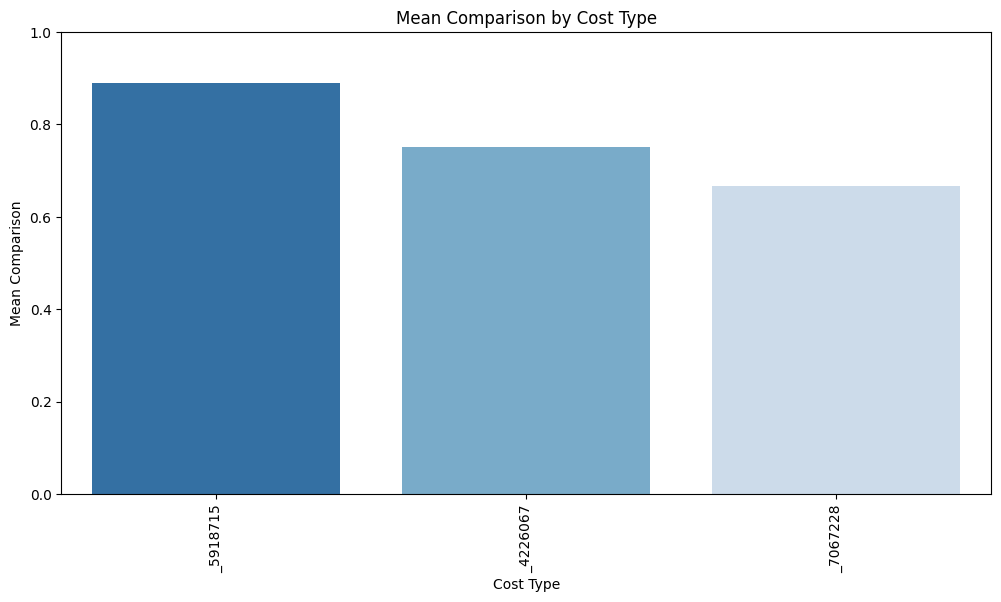

In [ ]:
df_sorted = df_sorted.sort_values(by="mean_comparison", ascending=False)

# Plot erstellen
plt.figure(figsize=(12, 6))
sns.barplot(x=df_sorted["cost_type"], y=df_sorted["mean_comparison"], palette="Blues_r")

# Achsentitel und Styling
plt.xlabel("Cost Type")
plt.ylabel("Mean Comparison")
plt.title("Mean Comparison by Cost Type")
plt.ylim(0, 1)  # Wertebereich 0 bis 1 festlegen
plt.xticks(rotation=90)  # X-Achsen-Beschriftung drehen, falls viele Einträge

plt.show()

In [ ]:
df_sample_only_false_values = df_sample[df_sample['comparison_result'] == False]
df_sample_only_false_values

,Response,cost_type,reply_category,comparison_result
27,ller: Innovative Patente GmbH\nAdresse: Muster...,_7067228,_6708456,False
144,"ller: Schmidt & Partner Rechtsanwälte, Patente...",_7067228,_6708456,False
206,ller: Patentanwaltskanzlei Musterservice GmbH\...,_7067228,_6708456,False
223,n\n\nRechnungssteller: Umwelt & Co. GmbH\nAnsc...,_4226067,_6708456,False
255,ller: Innovative Technologien GmbH\nAdresse: I...,_5918715,_1499914,False
298,ller: ÖkoConsult GmbH\nRechnungsnummer: 2023-E...,_4226067,_5918715,False


# 5 Results

The results of the last run look amazing. Changing the input of the model by reducing the cost_types supported the LLM with clearer boundaries and reinforced accuracy by a great margin.

294/300 Samples have been classified correctly into the now 40 categories, which is a accurracy of **98%.** This is 3 percentage points higher than the targeted 95% of the project goal. Three of the 6 samples that have been classified false are of the cost_types "patent law consulting cost" and "legal consulting cost" which are adjacent, and might also be combined to one cost_type.

Note also that this test has been conducted not with o3 but with 4o-mini, which is a weaker model, but changing the input was enough to have stable results nevertheless. This has the advantage of a faster throughput-time, and reduces costs and environmental impact.

In a real world scenario this workbook serves as a proof-of-concept as well as a foundation for a productive working model.

**Lessons learned**:



*   LLM's as well as humans can have problems when being confronted with the problem of labeling something that can fit into multiple categories. Reducing the categories and redundancy to have more clear categories was key in enhancing the accurracy.

*   When the input is optimal for the LLM, a weaker model can present similar results like traditionally more "smart" models, but cost less tokens and calculation effort.

* The confidence that the model reported was not helpful in identifying cases where the prediction was wrong. The models are confident about their answer, even when they are clearly wrong. This seems to be a general weakness of LLMs, a point which might be enhanced in the coming years.


